In [192]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [193]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

In [194]:
# Keras functions
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD, Adam
from keras import metrics

# Keras dataset
from keras.datasets import mnist

# Keras utilis function
from keras.utils import np_utils

from keras import backend as K

In [195]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

print("There are %d training data with size %d x %d" %x_train0.shape)
print("There are %d testing  data with size %d x %d" %x_test0.shape)

There are 60000 training data with size 28 x 28
There are 10000 testing  data with size 28 x 28


In [196]:
x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

x_train -= x_train.min()
x_train = x_train/x_train.max()

In [197]:
x = Input(shape=(784,))

enc_1 = Dense(100, activation='sigmoid')
enc_2 = Dense(2, activation='sigmoid')

h = enc_2(enc_1(x))

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

x_hat = dec_1(dec_2(h))

In [198]:
autoencoder = Model(x, x_hat)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_52 (Dense)             (None, 2)                 202       
_________________________________________________________________
dense_53 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_54 (Dense)             (None, 784)               79184     
Total params: 158,186
Trainable params: 158,186
Non-trainable params: 0
_________________________________________________________________


In [199]:
autoencoder.compile(loss='mse', optimizer=Adam())

In [200]:
#autoencoder.fit(x_train, x_train, batch_size=1024, epochs=20)
#autoencoder.save('autoencoder_claire.h5')
autoencoder.load_weights('autoencoder_claire.h5')

In [201]:
Encoder = Model(x, h)
Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_52 (Dense)             (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [202]:
h_input = Input(shape=(2,))
Decoder = Model(h_input, dec_1(dec_2(h_input)))

Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_53 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_54 (Dense)             (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


In [203]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, Encoder.predict(x_train[idx: idx+1])))

第 28761 圖的 latent 表示為 [[0.8404242  0.55415016]]


In [204]:
indices = np.random.randint(x_test.shape[0], size=3000)

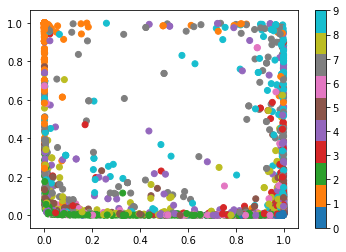

In [205]:
latents = Encoder.predict(x_test[indices])
plt.scatter(latents[:, 0], latents[:, 1], c=y_test0[indices], cmap="tab10")
plt.colorbar()
plt.show()

In [206]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)

In [207]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[(n-i-1) * digit_size: (n - i) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

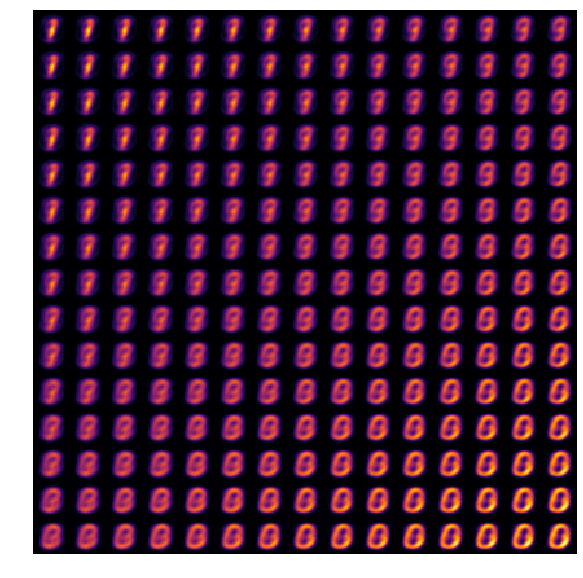

In [208]:
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='inferno')
plt.axis('off')
plt.show()

In [209]:
enc_1 = Dense(100, activation='sigmoid')
enc_2 = Dense(2, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [210]:
x = Input(shape=(784,))
enc_x1 = enc_1(x)
enc_x = enc_2(enc_x1)
z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [211]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [212]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [213]:
dec_x = dec_2(z)
x_hat = dec_1(dec_x)

In [214]:
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 784)          0                                            
__________________________________________________________________________________________________
dense_55 (Dense)                (None, 100)          78500       input_18[0][0]                   
__________________________________________________________________________________________________
dense_56 (Dense)                (None, 2)            202         dense_55[0][0]                   
__________________________________________________________________________________________________
dense_57 (Dense)                (None, 2)            6           dense_56[0][0]                   
__________________________________________________________________________________________________
dense_58 (

In [215]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

In [216]:
VAE.compile(loss=vae_loss, optimizer=Adam())

In [217]:
#VAE.fit(x_train, x_train, batch_size=32, epochs=20)
#VAE.save('VAE_Claire.h5')
VAE.load_weights('VAE_Claire.h5')

In [218]:
VAE_Encoder = Model(x, z_mean)
VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_56 (Dense)             (None, 2)                 202       
_________________________________________________________________
dense_57 (Dense)             (None, 2)                 6         
Total params: 78,708
Trainable params: 78,708
Non-trainable params: 0
_________________________________________________________________


In [219]:
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))
VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_59 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_60 (Dense)             (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


In [220]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, VAE_Encoder.predict(x_train[idx: idx+1])))

第 56031 圖的 latent 表示為 [[-0.3645476  0.4073981]]


In [221]:
# indices = np.random.randint(x_test.shape[0], size=1000)
VAE_latents = VAE_Encoder.predict(x_test[indices])

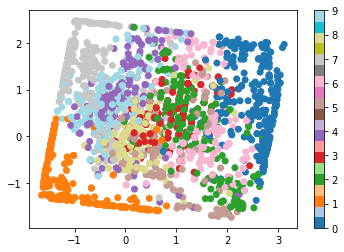

In [222]:
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()
plt.show()

In [223]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [224]:
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

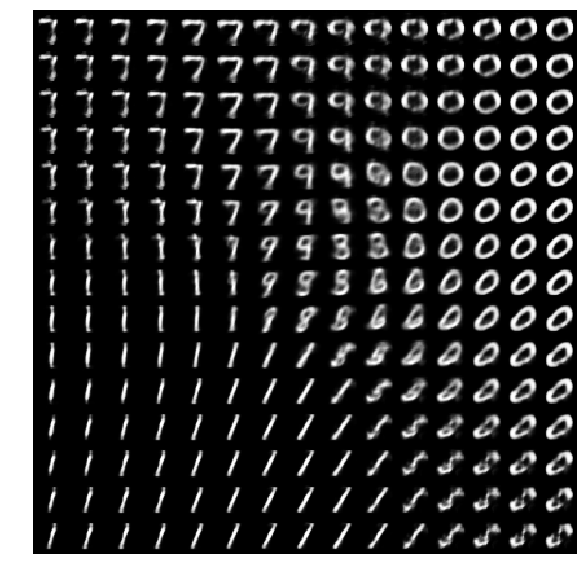

In [225]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='gray')
plt.axis('off')
plt.show()

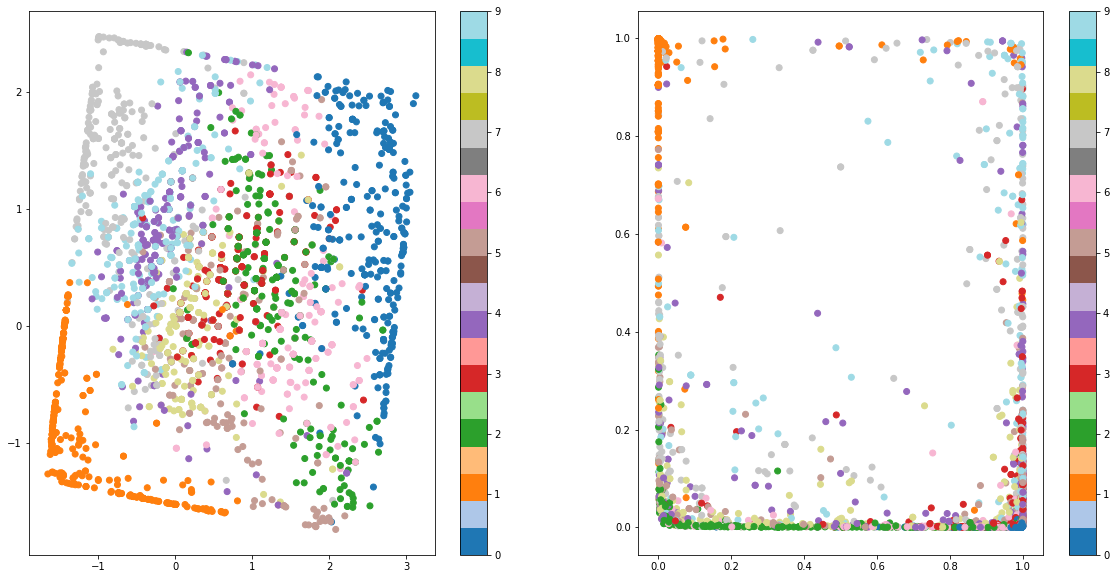

In [226]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(latents[:, 0], latents[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()
plt.show();

In [227]:
def inBetween(t):
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1-t)*x_train0[idx_1] + t*x_train0[idx_2]

    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='bone')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')

In [228]:
idx_1, idx_2 = np.random.randint(x_test.shape[0], size=2)
data_0 = x_train0[idx_1]
data_1 = x_train0[idx_2]

In [229]:
interact(inBetween, t=FloatSlider(value=0.5, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>